#  Amazon Review Sentiment Classification using TF-IDF and SVM




## Project Overview

This project focuses on using NLP techniques to automatically classify Amazon customer reviews into sentiment categories. The goal is to understand how customers feel about products and services.

We use a combination of **TF-IDF vectorization** and a **Support Vector Machine (SVM)** classifier to build an effective model.


## 🎯 Project Goals and Approach

Our goal is to classify Amazon product reviews into Positive, Neutral, and Negative sentiments to gain actionable customer insights. To achieve this:

- We assign initial sentiment labels based on star ratings and refine them using VADER sentiment analysis for better context understanding.
- Review texts are converted into numerical features using **TF-IDF vectorization**.
- A **Support Vector Classifier (SVC)** with a linear kernel is trained, with `class_weight='balanced'` to handle class imbalances fairly.
- We evaluate the model using accuracy, F1-score, and confusion matrices.
- Finally, we generate a structured output dataset containing predicted sentiments and confidence scores, ready for further analysis or integration.


In [1]:
# Cell 1: Install VADER Sentiment Analyzer
# This cell installs the vaderSentiment library, which is used for lexicon-based sentiment analysis.
!pip install vaderSentiment

In [2]:
# Cell 2: Import Libraries
# This cell imports all the necessary Python libraries for data manipulation,
# machine learning, natural language processing, and visualization.
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations, especially with arrays
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets
from sklearn.linear_model import LogisticRegression # Although LogisticRegression was mentioned in description, SVC is used later
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report # For model evaluation
import seaborn as sns # For enhanced data visualization
import matplotlib.pyplot as plt # For plotting and visualizing data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Specifically for VADER sentiment analysis
from sklearn.utils import resample # For resampling techniques, useful for handling class imbalance (though SVC's class_weight is used)
from sklearn.preprocessing import LabelEncoder # For encoding categorical labels into numerical format (if needed, not explicitly used for y)



## STEP 1: Load and Inspect Dataset

In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/1429_1.csv",low_memory=False)

# Basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head(4))


Dataset shape: (34660, 21)
Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username']

First few rows:
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   

        asins   brand                                         categories  \
0  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tab

In [4]:
# Look at the key columns
print(df[['reviews.rating', 'reviews.text']].head())

   reviews.rating                                       reviews.text
0             5.0  This product so far has not disappointed. My c...
1             5.0  great for beginner or experienced person. Boug...
2             5.0  Inexpensive tablet for him to use and learn on...
3             4.0  I've had my Fire HD 8 two weeks now and I love...
4             5.0  I bought this for my grand daughter when she c...


## Step 2: Create Initial Sentiment Labels from Ratings

In [5]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)


# Step 3: VADER Sentiment Analysis and Label Reconciliation

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()

# Labeling function using VADER
def vader_label(text):
    scores = analyzer.polarity_scores(str(text))
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis to the actual review text
df['vader_sentiment'] = df['reviews.text'].apply(vader_label)

# Check mismatches between VADER sentiment and original label
mismatches = df[df['vader_sentiment'] != df['sentiment']]
print(f"Number of label mismatches: {len(mismatches)}")

# This ensures that long text in the 'reviews.text' column is not truncated.
pd.set_option('display.max_colwidth', None)

display_mismatches = mismatches[['reviews.text', 'reviews.rating', 'sentiment', 'vader_sentiment']]
print(display_mismatches.head(3))

# Optionally trust VADER sentiment over original labels
df['final_label'] = df['vader_sentiment']

# See distribution of final labels
print(df['final_label'].value_counts())



Number of label mismatches: 4396
                                                                                                                                                         reviews.text  \
10                                                                                                               Not easy for elderly users cease of ads that pop up.   
17  I really like this tablet. I would have given 5 stars but sometimes you have to push start several times after you unlock the screen and it is a little annoying.   
53                                                                                                            This fire tablet has long battery life. Reasonable fast   

    reviews.rating sentiment vader_sentiment  
10             4.0  positive        negative  
17             4.0  positive        negative  
53             4.0  positive        negative  
final_label
positive    31252
negative     1895
neutral      1513
Name: count, dtype: int64


#Step 4: Feature Extraction using TF-IDF

In [16]:
df['reviews.text'] = df['reviews.text'].replace(np.nan, '')
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['reviews.text'])
y = df['final_label']

#Step 5: Train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (27728, 5000)
Shape of X_test: (6932, 5000)
Shape of y_train: (27728,)
Shape of y_test: (6932,)


#Step 6: Model Training and Prediction(Support Vector Classifier - SVC)

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
svc_model = SVC(kernel='linear', probability=True, random_state=42,class_weight='balanced')

print("\nTraining the SVC model...")
svc_model.fit(X_train, y_train)


Training the SVC model...


SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

In [19]:
y_pred = svc_model.predict(X_test)

# 4. Evaluate the model's performance
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.8568

Classification Report:
              precision    recall  f1-score   support

    negative       0.32      0.71      0.44       379
     neutral       0.36      0.65      0.46       303
    positive       0.99      0.88      0.93      6250

    accuracy                           0.86      6932
   macro avg       0.56      0.74      0.61      6932
weighted avg       0.92      0.86      0.88      6932



# Step 7: Model evaluation and results

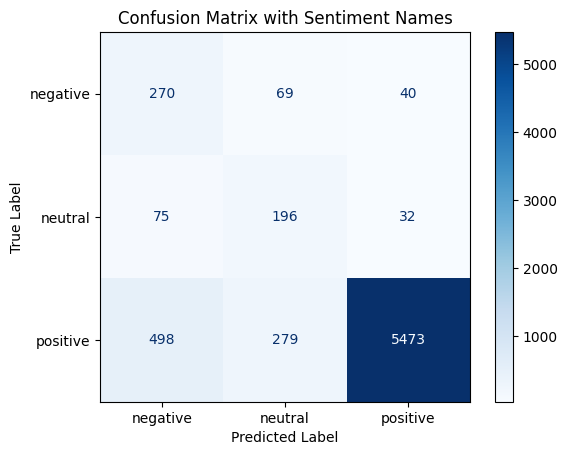

In [ ]:

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = svc_model.classes_
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
# Display the confusion matrix with sentiment names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Sentiment Names')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [20]:
# 1. Get predicted sentiment for the entire dataset using the trained SVC model
all_predicted_sentiment = svc_model.predict(X)

# 2. Get probabilities for the entire dataset
# This array will have a column for each class (e.g., [proba_negative, proba_neutral, proba_positive])
all_probabilities = svc_model.predict_proba(X)

# 3. Determine the confidence score for each prediction
# The confidence score is the probability of the *predicted* class
confidence_scores = []
class_labels = svc_model.classes_ # Get the order of classes from the model (e.g., ['negative', 'neutral', 'positive'])

for i, pred_sentiment in enumerate(all_predicted_sentiment):
    # Find the index of the predicted sentiment in the class_labels array
    # e.g., if pred_sentiment is 'positive' and class_labels is ['negative', 'neutral', 'positive'],
    # then predicted_class_index will be 2
    predicted_class_index = list(class_labels).index(pred_sentiment)

    # Get the probability for that specific predicted class for the current review
    confidence = all_probabilities[i, predicted_class_index]
    confidence_scores.append(confidence)

# 4. Create the final DataFrame for export
results_df = pd.DataFrame({
    # IMPORTANT: Replace 'your_product_id_column_name' with the actual column name from your original df
    # e.g., if it's 'id', use df['id']
    # If there's no such column, you can use df.index like: 'product_index': df.index
    'product_id': df['id'], # <--- **ADJUST THIS LINE**
    'reviews.text': df['reviews.text'],
    'rating': df['reviews.rating'],
    'original_sentiment_from_rating': df['sentiment'], # This is your initial rule-based sentiment
    'predicted_sentiment_SVC': all_predicted_sentiment, # Sentiment predicted by the SVC model
    'prediction_confidence': confidence_scores # Confidence for the predicted sentiment
})

# 5. Export to CSV
output_filename = 'product_reviews_sentiment_and_confidence.csv'
results_df.to_csv(output_filename, index=False) # index=False prevents writing DataFrame index as a column

print(f"\nSuccessfully generated '{output_filename}' with sentiment and confidence scores.")
print(f"Preview of the generated CSV file (first 5 rows):\n{results_df.head()}")


Successfully generated 'product_reviews_sentiment_and_confidence.csv' with sentiment and confidence scores.
Preview of the generated CSV file (first 5 rows):
             product_id  \
0  AVqkIhwDv8e3D1O-lebb   
1  AVqkIhwDv8e3D1O-lebb   
2  AVqkIhwDv8e3D1O-lebb   
3  AVqkIhwDv8e3D1O-lebb   
4  AVqkIhwDv8e3D1O-lebb   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviews.text  \
0                                                         

##  Summary

This notebook presents a sentiment analysis pipeline for Amazon product reviews using Natural Language Processing (NLP) techniques and machine learning models.

- Star ratings were used to generate initial sentiment labels (positive, neutral, negative).
- VADER sentiment analysis helped refine those labels to better reflect the actual sentiment expressed in review texts.
- TF-IDF vectorization was applied to convert text into numerical features.
- A Support Vector Classifier (SVC) with a linear kernel and `class_weight='balanced'` was trained on the dataset.
- Model performance was evaluated using accuracy, F1-score, and a confusion matrix.
- Undersampling was experimented with to balance the class distribution, but due to the limited size of minority classes, it reduced the dataset to ~1,500 samples and degraded performance.
- A deep learning approach using DistilBERT was explored in a separate notebook for improved text understanding (not covered here).
- A CSV file containing review text, predicted sentiment, and confidence scores was generated for downstream use.

---

##  Results

The TF-IDF + SVC model achieved:

- **Accuracy:** **85.68%**
- **Classification Report:**

Classification Report:
              precision    recall  f1-score   support

    negative       0.32      0.71      0.44       379
     neutral       0.36      0.65      0.46       303
    positive       0.99      0.88      0.93      6250

    accuracy                           0.86      6932
    macro avg       0.56      0.74      0.61      6932
    weighted avg    0.92      0.86      0.88      6932



### 📊 Classification Report Summary

- **Positive (majority class)**:
  - High precision (0.99) and recall (0.88) → model performs very well here.
- **Neutral & Negative (minority classes)**:
  - Low precision (0.36 & 0.32) → many false positives.
  - Decent recall (0.65 & 0.71) → model finds most true samples but misclassifies others as them.
- **Macro Avg F1-score: 0.61** → Shows poor performance on minority classes.
- **Weighted Avg F1-score: 0.88** and **accuracy: 86%** are inflated by class imbalance.

⚠️ **Key Issue**: Model is biased toward the positive class. It struggles to correctly identify neutral and negative reviews — needs balancing.
